# Assignment 2 - House Prices: Advanced Regression Techniques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
sns.set()

## Import Data
'train_clean.csv' and 'test_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
# Create file path
train_clean_file = os.path.join(os.getcwd(), 'data', 'train_clean.csv')
test_clean_file = os.path.join(os.getcwd(), 'data', 'test_clean.csv')

# Load csv into pandas df
df_train_clean = pd.read_csv(train_clean_file)
df_test_clean = pd.read_csv(test_clean_file)

df_train_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [3]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1458 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          1458 non-null   object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallC

In [4]:
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Prep the data for analysis

In [5]:
# train set
x_train = df_train_clean.drop(columns=["SalePrice"], axis=1)
y_train = df_train_clean['SalePrice']

x_train.shape, y_train.shape, df_train_clean.shape

((1458, 84), (1458,), (1458, 85))

### Filter data to look at significant features and remove the features with a correlation score < 0.5 with SalePrice

In [6]:
corr_mat = df_train_clean.corr()
corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.40) | (corr_mat["SalePrice"] < -0.40)]

OverallQual     0.795774
YearBuilt       0.523608
YearRemodAdd    0.507717
MasVnrArea      0.477810
BsmtFinSF1      0.409384
TotalBsmtSF     0.651153
1stFlrSF        0.631530
GrLivArea       0.734968
FullBath        0.562165
TotRmsAbvGrd    0.537769
Fireplaces      0.469862
FireplaceQu     0.521144
GarageYrBlt     0.508719
GarageCars      0.641047
GarageArea      0.629217
SalePrice       1.000000
TotalSqft       0.832877
TotalBath       0.635896
HouseAge       -0.524067
Name: SalePrice, dtype: float64

#### Look at only the important numerical features

In [7]:
important_num_cols = list(corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.5) | (corr_mat["SalePrice"] < -0.5)].index)

important_num_cols.remove('SalePrice')
len(important_num_cols)
print(important_num_cols)

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalSqft', 'TotalBath', 'HouseAge']


In [8]:
x_num_only = x_train[important_num_cols]
x_num_only.shape

(1458, 15)

#### Look at the features that are highly correlated with each other and drop them from our analysis.
We do this so to remove the 'noise' from our data as it will impact our regression model by feeding it the same information.

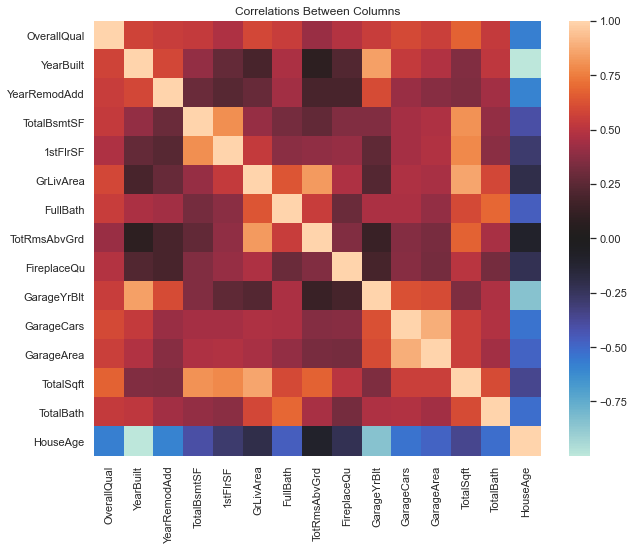

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(x_num_only.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

In [10]:
corr_x = x_num_only.corr()
len(corr_x)

15

In [11]:
for i in range(0, len(corr_x) - 1):
    for j in range(i + 1, len(corr_x)):
        if(corr_x.iloc[i, j] < -0.6 or corr_x.iloc[i, j] > 0.6):
            print(f"corr: {corr_x.iloc[i, j]}, row: {i}, column: {j}; {corr_x.index[i]}, {corr_x.index[j]}")

corr: 0.6007408233586187, row: 0, column: 10; OverallQual, GarageCars
corr: 0.677324662815223, row: 0, column: 12; OverallQual, TotalSqft
corr: 0.8448398583188299, row: 1, column: 9; YearBuilt, GarageYrBlt
corr: -0.9990342610821568, row: 1, column: 14; YearBuilt, HouseAge
corr: 0.6036359426335961, row: 2, column: 9; YearRemodAdd, GarageYrBlt
corr: 0.8038296279256137, row: 3, column: 4; TotalBsmtSF, 1stFlrSF
corr: 0.8063997413782675, row: 3, column: 12; TotalBsmtSF, TotalSqft
corr: 0.7819168108101032, row: 4, column: 12; 1stFlrSF, TotalSqft
corr: 0.6383784637415114, row: 5, column: 6; GrLivArea, FullBath
corr: 0.8294981976715387, row: 5, column: 7; GrLivArea, TotRmsAbvGrd
corr: 0.8663861141668217, row: 5, column: 12; GrLivArea, TotalSqft
corr: 0.6932148078878521, row: 6, column: 13; FullBath, TotalBath
corr: 0.678560717489618, row: 7, column: 12; TotRmsAbvGrd, TotalSqft
corr: 0.6195177230785254, row: 9, column: 10; GarageYrBlt, GarageCars
corr: 0.6030387164134533, row: 9, column: 11; Ga

In [12]:
# from the information above, we want to drop '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', and 'GarageArea'
num_cols = [i for i in x_num_only.columns if i not in ['1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageArea']]
num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'TotalSqft',
 'TotalBath',
 'HouseAge']

In [13]:
num_df_train = x_train[num_cols]
num_df_train.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,HouseAge
0,7,2003,2003,856,1710,0,2003.0,2,2566,3.5,5
1,6,1976,1976,1262,1262,3,1976.0,2,2524,2.5,31
2,7,2001,2002,920,1786,3,2001.0,2,2706,3.5,7
3,7,1915,1970,756,1717,4,1998.0,3,2473,2.0,91
4,8,2000,2000,1145,2198,3,2000.0,3,3343,3.5,8


#### Update 'YearRemodAdd' to show how long it has been for when the house was built and when it was remodeled

In [16]:
# disabling the pandas warning
pd.options.mode.chained_assignment = None

num_df_train['YearRemodAdd'] = num_df_train['YearRemodAdd'] - num_df_train['YearBuilt']
# x_final_test['YearRemodAdd'] = x_final_test['YearRemodAdd'] - x_final_test['YearBuilt']

num_df_train.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,HouseAge
0,7,2003,0,856,1710,0,2003.0,2,2566,3.5,5
1,6,1976,0,1262,1262,3,1976.0,2,2524,2.5,31
2,7,2001,1,920,1786,3,2001.0,2,2706,3.5,7
3,7,1915,55,756,1717,4,1998.0,3,2473,2.0,91
4,8,2000,0,1145,2198,3,2000.0,3,3343,3.5,8


#### Select the important categorical features to use

In [17]:
cat_cols = ["MSZoning", "Utilities", "BldgType", "Heating", 
            "KitchenQual", "SaleCondition", "LandSlope"]

cat_df_train = pd.get_dummies(x_train[cat_cols], columns=cat_cols)
cat_df_train.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Utilities_AllPub,Utilities_NoSeWa,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
0,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
2,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


### Create final dataframe

In [19]:
x_train_final = num_df_train.join(cat_df_train)
x_train_final.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,...,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
0,7,2003,0,856,1710,0,2003.0,2,2566,3.5,...,0,0,0,0,0,1,0,1,0,0
1,6,1976,0,1262,1262,3,1976.0,2,2524,2.5,...,1,0,0,0,0,1,0,1,0,0
2,7,2001,1,920,1786,3,2001.0,2,2706,3.5,...,0,0,0,0,0,1,0,1,0,0
3,7,1915,55,756,1717,4,1998.0,3,2473,2.0,...,0,1,0,0,0,0,0,1,0,0
4,8,2000,0,1145,2198,3,2000.0,3,3343,3.5,...,0,0,0,0,0,1,0,1,0,0


## Normalize the data

### Standardize the numeric columns

In [20]:
ss_train = StandardScaler().fit(x_train_final[num_cols])
ss_test = StandardScaler().fit(x_train_final[num_cols])

ss_train.mean_

array([6.09396433e+00, 1.97121811e+03, 1.36159122e+01, 1.05253704e+03,
       1.51046571e+03, 1.82235940e+00, 1.97646502e+03, 1.76611797e+00,
       2.55715021e+03, 2.20747599e+00, 3.65980796e+01])

In [26]:
#transform
x_train_final[num_cols] = ss_train.transform(x_train_final[num_cols])
# x_final_test[num_cols] = ss_test.transform(x_final_test[num_cols])

x_train_final.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,...,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
0,-12.790488,-67.545872,-0.579893,-2.543343,-2.980961,-2.186578,-78.149957,-21.700349,-3.308752,-18.909299,...,0,0,0,0,0,1,0,1,0,0
1,-12.937884,-67.545872,-0.579893,-2.543343,-2.980961,-2.101174,-78.149957,-21.700349,-3.308752,-23.313342,...,1,0,0,0,0,1,0,1,0,0
2,-12.790488,-67.545872,-0.579893,-2.543343,-2.980961,-2.101174,-78.149957,-21.700349,-3.308752,-18.909299,...,0,0,0,0,0,1,0,1,0,0
3,-12.790488,-67.545872,-0.579893,-2.543343,-2.980961,-2.072707,-78.149957,-15.937909,-3.308752,-25.515363,...,0,1,0,0,0,0,0,1,0,0
4,-12.643093,-67.545872,-0.579893,-2.543343,-2.980961,-2.101174,-78.149957,-15.937909,-3.308752,-18.909299,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
x_final_train.isna().sum()

In [ ]:
x_final_train.info()

In [ ]:
x_final_test.info()

In [ ]:
x_final_test.isna().sum()

In [ ]:
datatypes = x_train_final.dtypes
encodings = {}

for col, dt in datatypes.iteritems():
    if(str(dt) not in ['float64', 'int64']):
        
        #print(col, dt)
        x_cat_df[col] = x_cat_df[col].astype("category")
        encodings[col] = x_cat_df[col].cat.codes
        x_cat_df[col] = encodings[col]

In [ ]:
x_cat_df.head()

In [ ]:
x_final_train2 = num_df_train.join(x_cat_df)
x_final_train2.head()

In [ ]:
x_cat_df = X[cat_cols]

In [ ]:
x_final_train = x_train[num_cols]
x_final_train.shape

In [ ]:
x_final_train.columns

In [ ]:
# x_final_test = df_test_clean[num_cols]
# x_final_test.shape

In [ ]:
x_final = c_final.join(x_cat_df)
x_final

#### Perform a missing data check

In [ ]:
x_final_train.isna().sum()

In [ ]:
x_train[cat_cols].isna().sum()

In [ ]:
df_test_clean[cat_cols].isna().sum()

In [ ]:
x_train.info()

In [ ]:
df_test_clean.info()

### Encode the categorical data

In [ ]:
for col in x_final_train.columns:
    train = sorted(x_final_train[col].unique().tolist())
    test = sorted(x_final_test[col].unique().tolist())
    total = set(train + test)
    x_final_train[col] = pd.Categorical(x_final_train[col], categories=total)
    x_final_test[col] = pd.Categorical(x_final_test[col], categories=total)

In [ ]:
x_final_train.head()

In [ ]:
x_final_test.head()

In [ ]:
x_cat_df_train = pd.get_dummies(x_final_train, columns=cat_cols)
x_cat_df_test = pd.get_dummies(x_final_test, columns=cat_cols)

In [ ]:
x_cat_df_train = pd.get_dummies(x_final_train[cat_cols], columns=cat_cols)
x_cat_df_test = pd.get_dummies(x_final_test[cat_cols], columns=cat_cols)


x_cat_df_train.head()

In [ ]:
x_cat_df_test.head()

### Create the final dataframe

In [ ]:
x_final_train = x_final_train.join(x_cat_df_tran)
x_final_test = x_final_test.join(x_cat_df_test)

x_final_train

## Split the data into train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_final_train, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

## Run a Linear Regression looking at one feature

In [ ]:
x_final_train[['OverallQual']]

In [ ]:
len(x_train_overall_q)

In [ ]:
len(y_train)

In [ ]:
x_train_overall_q =x_train[['OverallQual']]
x_test_overall_q =x_test[['OverallQual']]

linreg = LinearRegression()
kf = KFold(n_splits=7, shuffle=True)

scores = cross_val_score(linreg, x_train_overall_q, y_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()}; SD: {scores.std()}')


linreg.fit(x_train_overall_q, y_train)
print(f'TRAIN Score: {linreg.score(x_train_overall_q, y_train)}')

print(f'TEST Score: {linreg.score(x_test_overall_q, y_test)}')



# # calculating the intercept and slope for the regression line
# b, m = np.polynomial.polynomial.polyfit(y_train, pred, 1)

# print('labels\n', x_train_overall_q.columns)
# print('Coefficients: \n', lin_reg.coef_)
# print('Intercept: \n', lin_reg.intercept_)
# print('R2 for Train:', lin_reg.score(x_train_overall_q, y_train))
# print('R2 for Test (cross validation)', lin_reg.score(x_train_overall_q, y_train))

In [ ]:
sns.scatterplot(x=y_train, y=pred, alpha=0.4)
sns.regplot(x=y_train, y=pred, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

## Run a Linear Regression looking at multiple feature

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
pred = lin_reg.predict(x_train)

kf = KFold(n_splits=7, shuffle=True)

scores = cross_val_score(lin_reg, x_train, y_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()}; SD: {scores.std()}')


linreg.fit(x_train, y_train)
print(f'TRAIN Score: {linreg.score(x_train, y_train)}')

print(f'TEST Score: {linreg.score(x_test, y_test)}')


# # calculating the intercept and slope for the regression line
# b, m = np.polynomial.polynomial.polyfit(y_train, pred, 1)

# print('labels\n', x_train_overall_q.columns)
# print('Coefficients: \n', lin_reg.coef_)
# print('Intercept: \n', lin_reg.intercept_)
# print('R2 for Train:', lin_reg.score(x_train, y_train))
# print('R2 for Test (cross validation)', lin_reg.score(x_train, y_train))

In [ ]:
sns.scatterplot(x=y_train, y=pred, alpha=0.4)
sns.regplot(x=y_train, y=pred, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

In [ ]:
x_final_test

In [ ]:
preds1 = linreg.predict(x_final_test)

In [ ]:
len(df_test_clean)

In [ ]:
len(x_final)

In [ ]:
preds = lin_reg.predict(x_final_test)
submit = pd.DataFrame({'Id': df_test_clean['Id'], 'SalePrice': preds})
submit
# submit.to_csv('submission.csv',index=False)

## 4. Evaluate polynomial, indicator, dichotomous, & piecewise model components

### Polynomial Regression

In [ ]:
# Creates a polynomial regression model for the given degree
poly_features = PolynomialFeatures(degree=2, include_bias=False)
   
# transform the features to higher degree features.
x_train_poly = poly_features.fit_transform(x_minmax_train)
   
# fit the transformed features to Linear Regression
poly_model = LinearRegression()

poly_model.fit(x_train_poly, y_train)

print(poly_model.intercept_)
print(lin_reg.coef_)
     
# predicting on training data-set
y_train_predicted = poly_model.predict(x_train_poly)
   
# predicting on test data-set
y_test_predicted = poly_model.predict(poly_features.fit_transform(x_test))

In [ ]:
y_train_residual = y_train_predicted - y_train
y_test_residual = y_test_predicted - y_test


fig, axes = plt.subplots(2, 1)
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=0.125, wspace=0.125)

plt.subplot(1, 2, 1)
sns.histplot(y_train_residual, bins=25)
plt.title('Training Set [Polynomial Model]')

plt.subplot(1, 2, 2)
sns.histplot(y_test_residual, bins=25)
plt.title('Test Set [Polynomial Model]')

plt.show()

In [ ]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(labels=["train","val"])

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x_minmax_train, y_train)

### Indicator

### Dichotomous
Dichotomous is when the axis is divided into 2 branches (such as yes or no). This is seen when prefroaming a Binary Logistic Regression.

[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
x3 = df_train_clean[['ReModeled']]
y3 = df_train_clean['SalePrice']
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3)

print(x_train3.shape, x_test3.shape, y_train3.shape, y_test3.shape)

In [ ]:
# Standardizing the scales
ss = StandardScaler()
xs3 = ss.fit_transform(x_train3)

clf = LogisticRegression()
clf.fit(xs3, y_train3)
print(f"Model Score: {clf.score(xs3, y_train3)}")


# model evaluation for training set
y_train_predict3 = clf.predict(xs3)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train3, y_train_predict3, 1)

In [ ]:
sns.scatterplot(x=y_train3, y=y_train_predict3, alpha=0.4)
sns.regplot(x=y_train3, y=y_train_predict3, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train3), y=np.unique(np.poly1d(b + m * np.unique(y_train3))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

### Piecewise model

In [ ]:
x4 = df_train_clean[['TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars']]
y4 = df_train_clean['SalePrice']
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4)

print(x_train4.shape, x_test4.shape, y_train4.shape, y_test4.shape)

In [ ]:
model = PiecewiseRegressor(verbose=True,
                           binner=DecisionTreeRegressor(min_samples_leaf=300))
model.fit(x_train4, y_train4)

In [ ]:
pred = model.predict(x_test4)
pred[:5]

In [ ]:
x_test4.iloc[:, 0].values

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test4.iloc[:, 0].values, y_test4, ".", label='data')
ax.plot(x_test4.iloc[:, 0].values, pred, ".", label="predictions")
ax.set_title("Piecewise Linear Regression\n2 buckets")
ax.legend();

In [ ]:
print(f"Model Score: {model.score(x_train4, y_train4)}")

## 5. Create at least one feature from the data set

In [ ]:
x_test_final = scaler.transform(df_test_clean)
preds = lasso_reg.predict(x_test_final)
preds = pd.DataFrame(preds,columns=['SalePrice'])
preds.head()

In [ ]:
preds['Id'] = x_test2['Id']
# preds = preds[['Id','SalePrice']]
preds

In [ ]:
preds